# Social Networks and Text Analysis - Centratility of Networks


## 1. What is centrality?

_Centrality_ is a term to describe importance of individual nodes in a graph.
There has been a lot of research carried out in this topic for network analysis to answer the question,
"Which are the most important nodes (vertices) in a graph?"
Here is the list of different metrics to find it, which I would like to discuss:

* [Degree Centrality](#Degree-Centrality)
* [Eigenvector Centrality](#Eigenvector-Centrality)
* [Katz Centrality](#Katz-Centrality)
* [Closeness Centrality](#Closeness-Centrality)
* [Betweenness Centrality](#Betweenness-Centrality)




In [99]:
#Some parts of this notebook are inspired by a notebook from Can Güney Aksakalli

#Importing the necessary libraries for this lab:
#------------------------------------------------

import networkx as nx #---> Library for network analysis
import matplotlib.pyplot as plt #---> Library for creating plots
import matplotlib.colors as mcolors #---> Library for setting colors of the plots
import numpy as np #---> Library for efficiently operating with arrays/matrices/vectors
import pandas as pd #---> Library for analysing dataframes
import seaborn as sns #---> Library forcreating plots
import random #---> Library for generating random numbers/distributions
from pylab import rcParams #---> Library for set the attributes of the figures


#Magic functions (%) for setting up the matplotlib and increase the resolution of the plots:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2. Network layouts with the Zachary's Karate Club:

Zachary’s Karate Club graph is defined as the example graph `G`.
It is basically a social network of members of an university karate club,
where undirected edges connects people who interact outside the club.

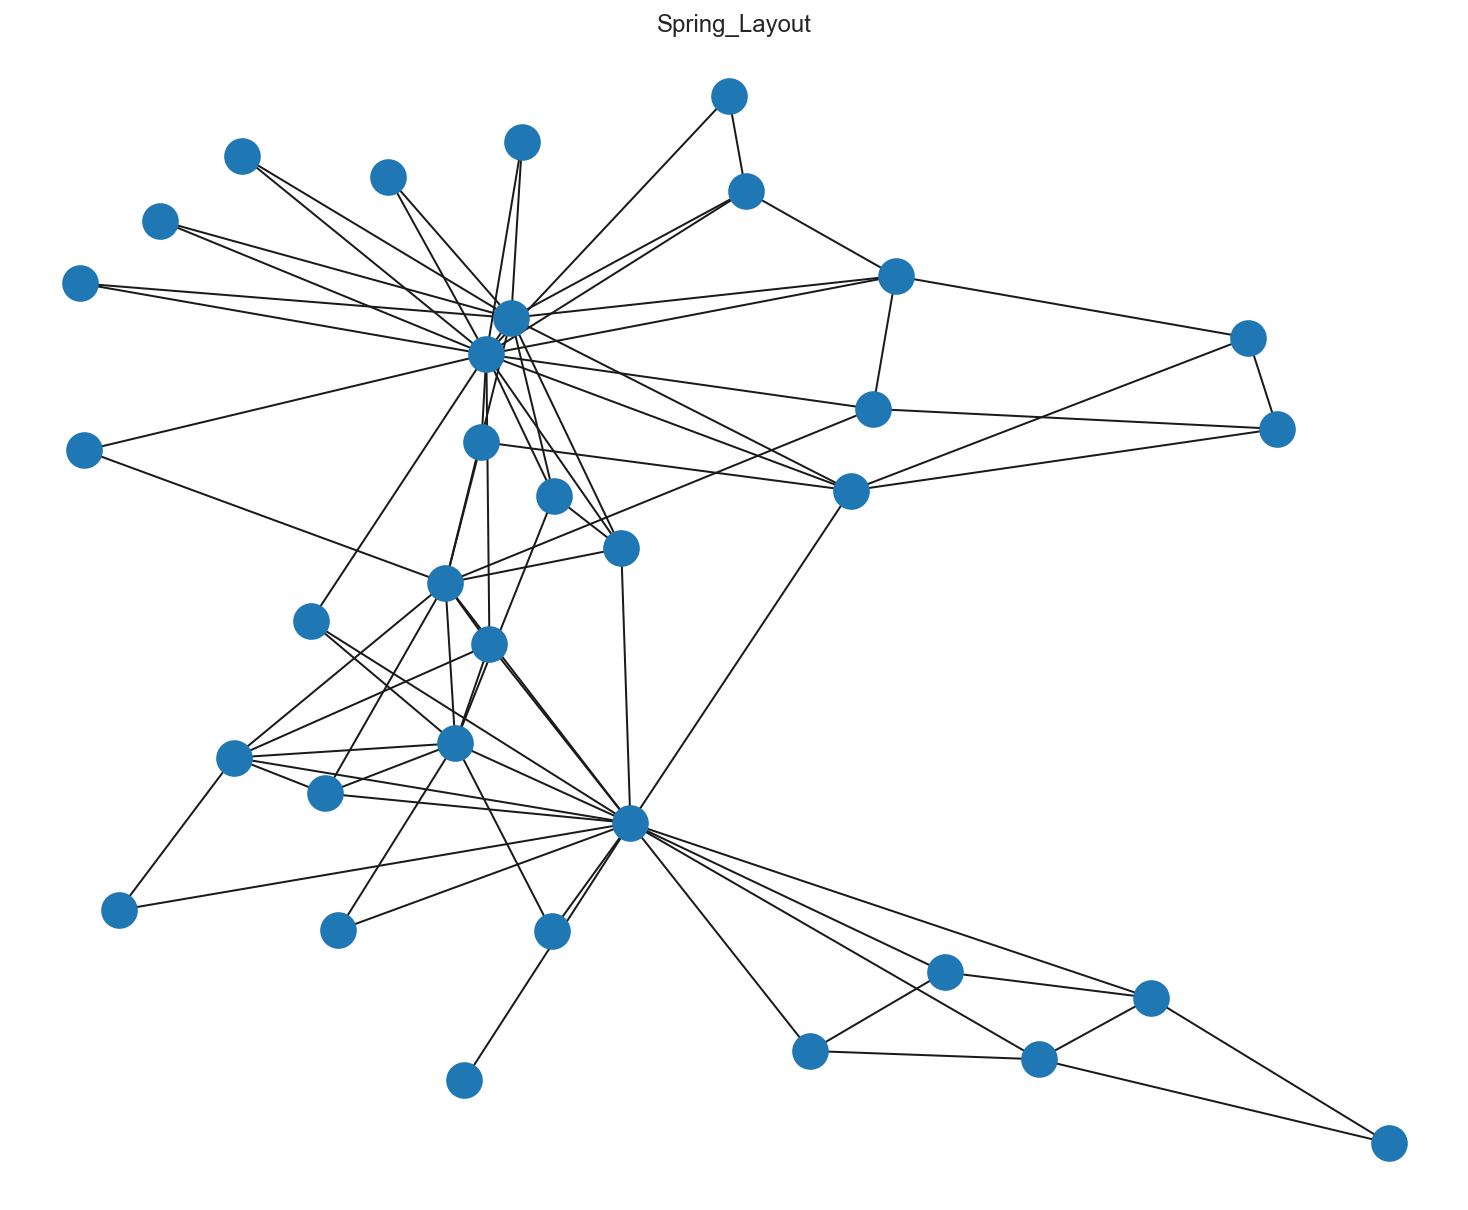

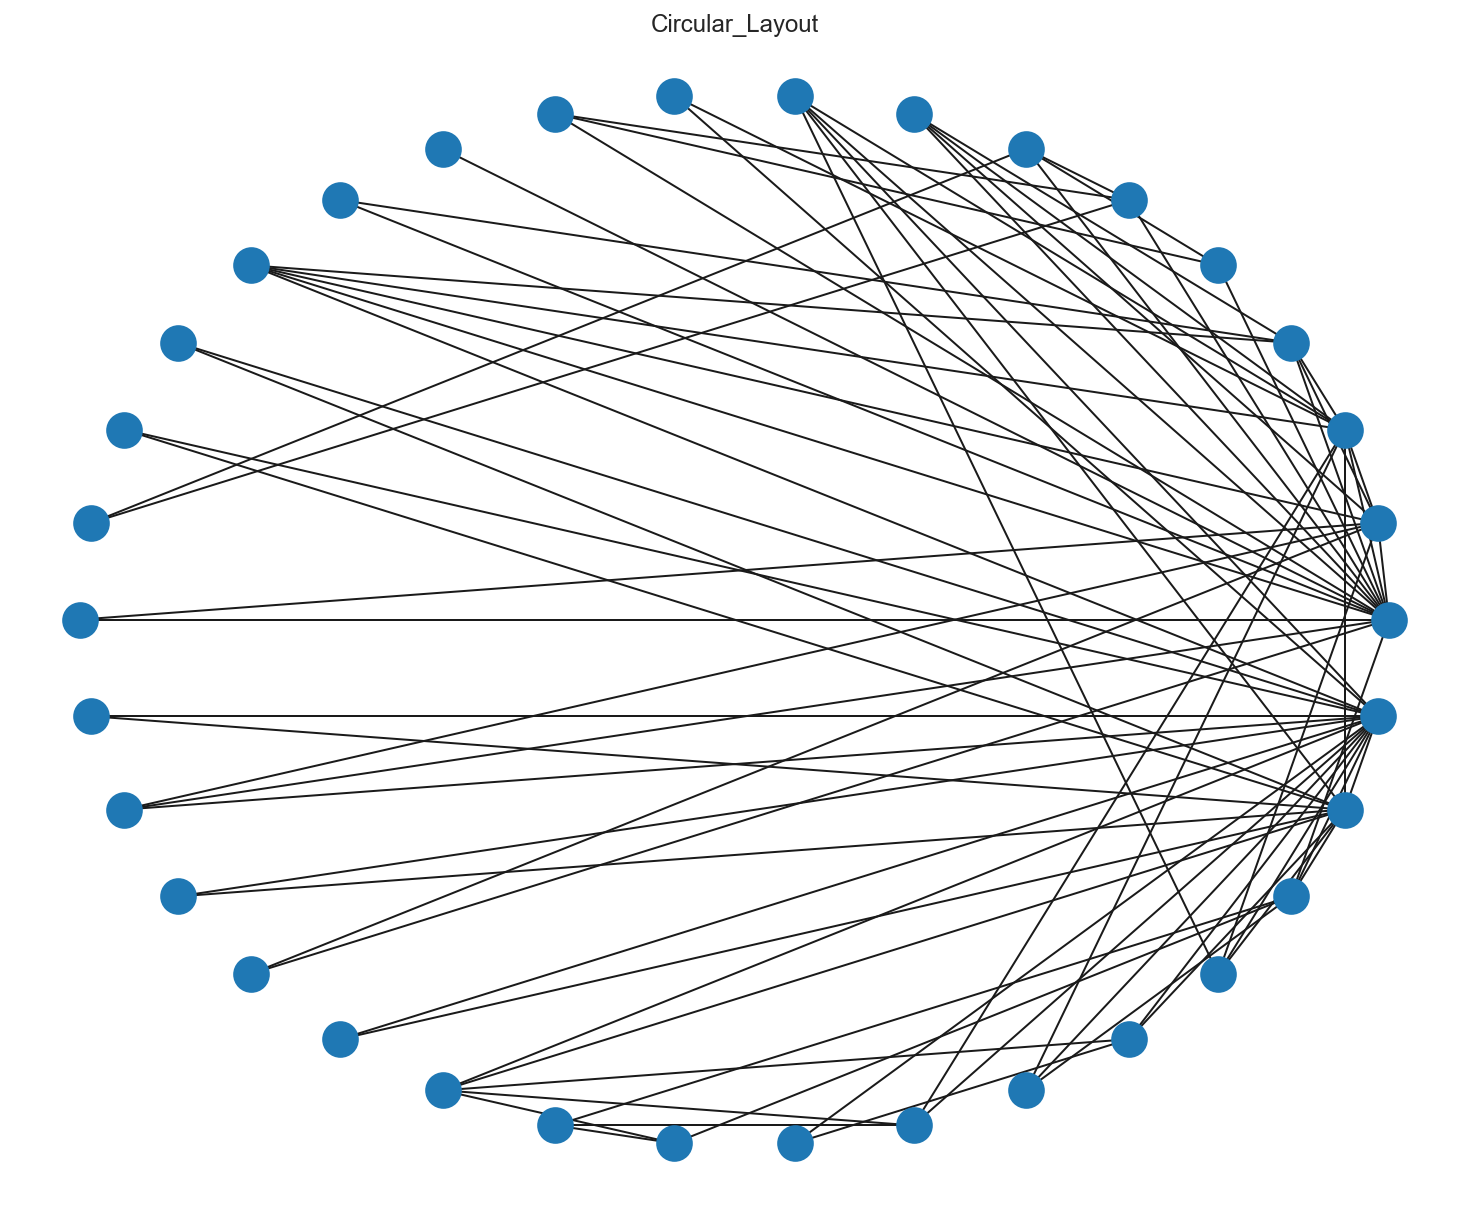

In [302]:
G = nx.karate_club_graph() #<-- Load the Karate club network

#1. Plotting the network with the first Layout:
#----------------------------------------------
pos = nx.spring_layout(G) #<-- Set the spring layout
nx.draw(G, pos=pos)
plt.title('Spring_Layout')
plt.show()

#1. Plotting the network with the second Layout:
#----------------------------------------------
pos = nx.circular_layout(G) #<-- Set the spring layout
nx.draw(G, pos=pos)
plt.title('Circular_Layout')
plt.show()



## 3. Example of weighted networks

Defining the Directed graph I will be using for the example

In [37]:
DiG = nx.DiGraph() #<-- Create a directed empty graph
DiG.add_edges_from([(2, 3), (3, 2), (4, 1), (4, 2), (5, 2), (5, 4),
                    (5, 6), (6, 2), (6, 5), (7, 2), (7, 5), (8, 2),
                    (8, 5), (9, 2), (9, 5), (10, 5), (11, 5)]) #<-- Adding the edges from a list of tupples
dpos = {1: [0.1, 0.9], 2: [0.4, 0.8], 3: [0.8, 0.9], 4: [0.15, 0.55],
        5: [0.5,  0.5], 6: [0.8,  0.5], 7: [0.22, 0.3], 8: [0.30, 0.27],
        9: [0.38, 0.24], 10: [0.7,  0.3], 11: [0.75, 0.35]} #<-- Set the nodes x and y position. 

In [38]:
#Add weight to the previous edges and save an edges file:
for e in DiG.edges():
    DiG[e[0]][e[1]]['weight'] = float(random.uniform(0, 1))
nx.write_edgelist(DiG, "network.edges")


## 4. Load a network from File of edges

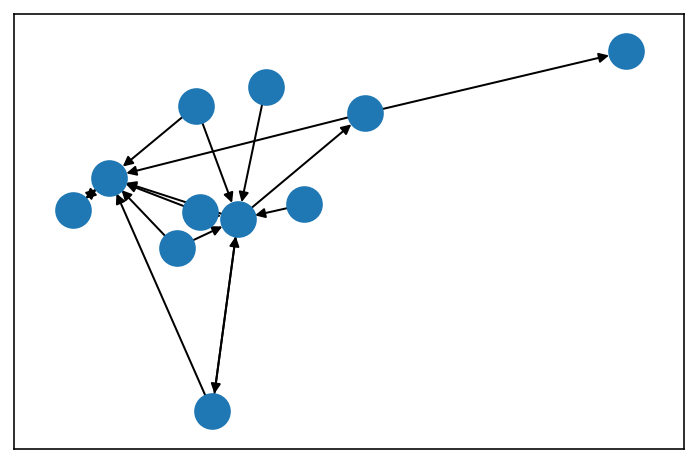

In [46]:
#Read the edges file:
fh=open("network.edges", 'r')
Gx=nx.read_edgelist(fh, nodetype=int, create_using=nx.DiGraph()) #<-- Read the network file with 
                                                                 # the type of network
pos = nx.spring_layout(Gx) #<-- Set the layout of the read network
nx.draw_networkx_edges(Gx, pos) #<-- Plot the edges of the network
nx.draw_networkx_nodes(Gx, pos) #<-- Plot the nodes of the network

In [47]:
#View the edges starting in node 2 and their wieght:
Gx[2]

AtlasView({3: {'weight': 0.8230290204376906}})

## 5. Following the Lecture 2 activity and playing with the layout and network attributes:

In [28]:
G = nx.karate_club_graph() #<-- Set the karate club network

We will use other two different layout to draw the netowrk G:

In [48]:
pos = nx.shell_layout(G) #<-- Set the position for the first layout
pos2 = nx.random_layout(G) #<-- Set the position for the second layout

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  This is separate from the ipykernel package so we can avoid doing imports until


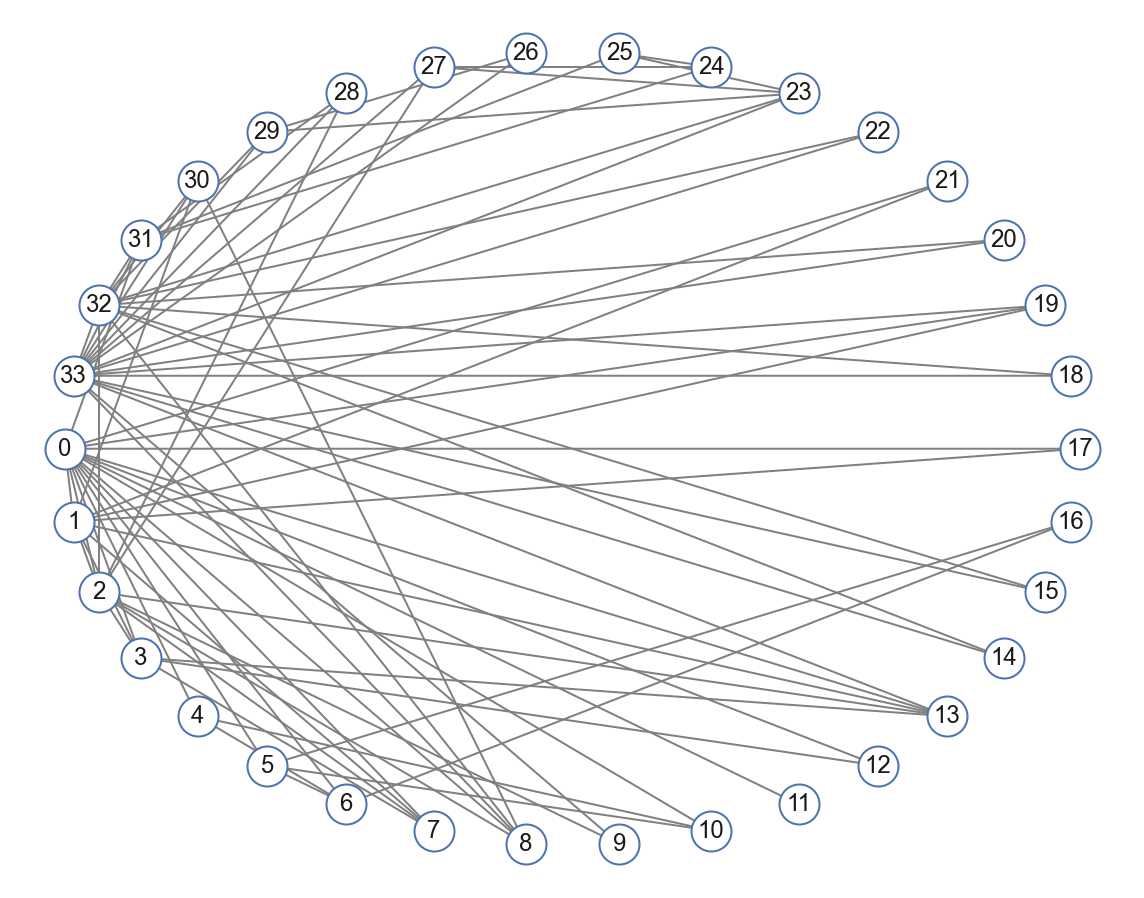

In [281]:

nodes = nx.draw_networkx_nodes(G, pos, node_size=400,node_color='White',edgecolors='b') #<-- Set the nodes plot

nodes.set_norm(mcolors.SymLogNorm(linthresh=0.03, linscale=2)) #<-- Seeting the color map of the nodes in a 
                                                               #symmetric logaritmic normalized scale

labels = {i:i for i in G.nodes()}
labels = nx.draw_networkx_labels(G, pos, labels, font_size=12) #<-- Set the labels plot

edges = nx.draw_networkx_edges(G, pos, edge_color = 'grey') #<-- Set the edges plot


plt.axis('off')
plt.savefig('shell_zachary_nolabel.eps')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  This is separate from the ipykernel package so we can avoid doing imports until


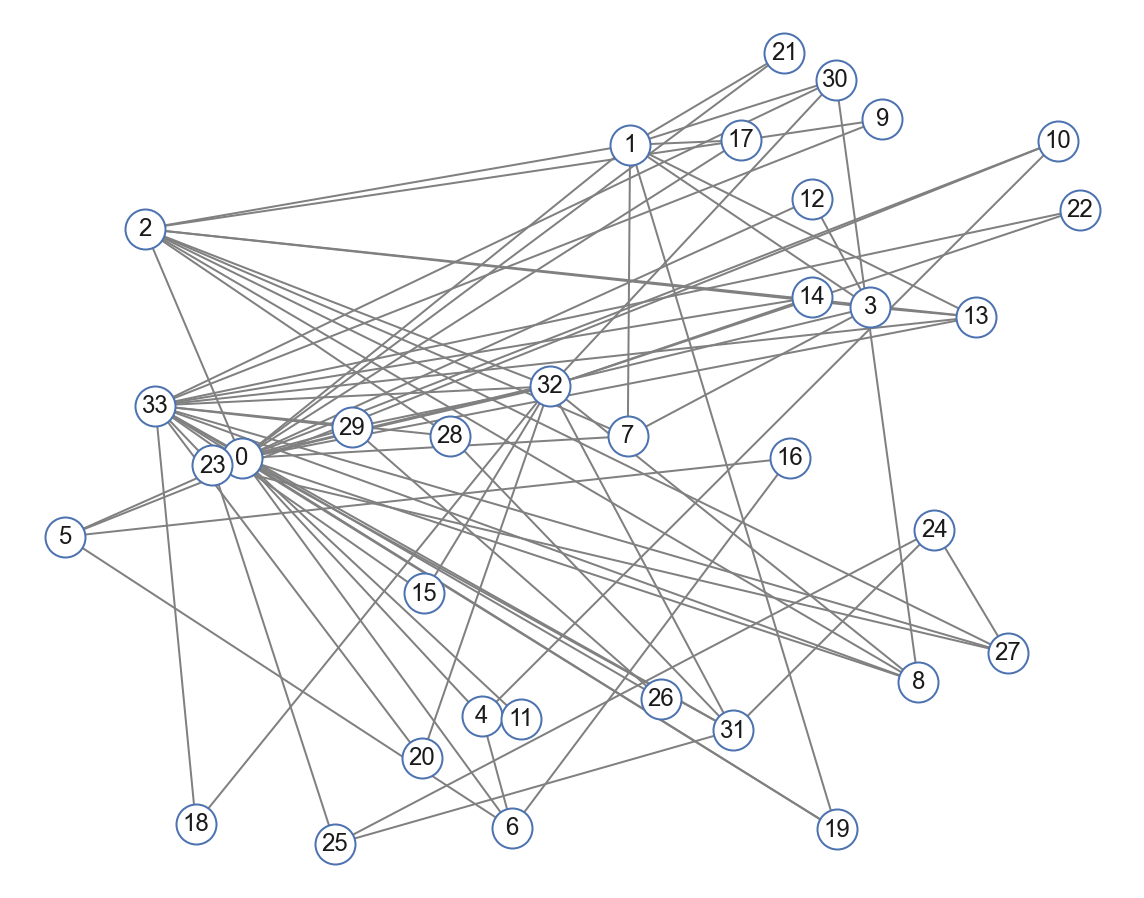

In [282]:
nodes = nx.draw_networkx_nodes(G, pos2, node_size=400,node_color='White',edgecolors='b')#<-- Set the nodes plot

nodes.set_norm(mcolors.SymLogNorm(linthresh=0.03, linscale=2)) #<-- Seeting the color map of the nodes in a 
                                                               #symmetric logaritmic normalized scale
labels = {k:k for k in range(len(pos2))} 

edges = nx.draw_networkx_edges(G, pos2, edge_color = 'grey') #<-- Set the edges plot
nx.draw_networkx_labels(G,pos2, labels, font_size=12)  #<-- Set the labels plot

plt.axis('off')
plt.savefig('shell_zachary_label.eps')
plt.show()

## 6. Function to plot the network:

First, we are defining a simple method to draw the graph and the centrality metrics of nodes with a heat map.

In [267]:
def draw(G, pos, measures, measure_name):
    '''This function draw a network based on a specific metric in the color and a specified layout
    
    Attributes:
    G: The networkx object
    pos: x and y coordinates of each node
    measures: dict with the node id as key and measure of centrality as value
    measure_name: string variable with the name of the plotted network '''
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=400, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys())) #<-- Set the node attributes to be plotted,
                                                                   # with the network, the nodes position, 
                                                                   # the color map for the measure that comes 
                                                                   # in numbers ranging in the color map
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.03, linscale=1)) #<-- Seeting the color map of the nodes in a 
                                                                   #symmetric logaritmic normalized scale
    
    labels = nx.draw_networkx_labels(G, pos, font_color='white') #<-- Set the node labels
    edges = nx.draw_networkx_edges(G, pos) #<-- Set the edges pisitions

    plt.title(measure_name) #<-- Set the title of the plot
    cbar = plt.colorbar(nodes) #--> set the range of the color bar

    cbar.set_label('Weight', rotation=270) #--> Set the label of the color bar and rotate it
    
    plt.axis('off') #<-- Remove the axis of the network plot
    plt.show()

## 7. Plot network nodes depending on a weight

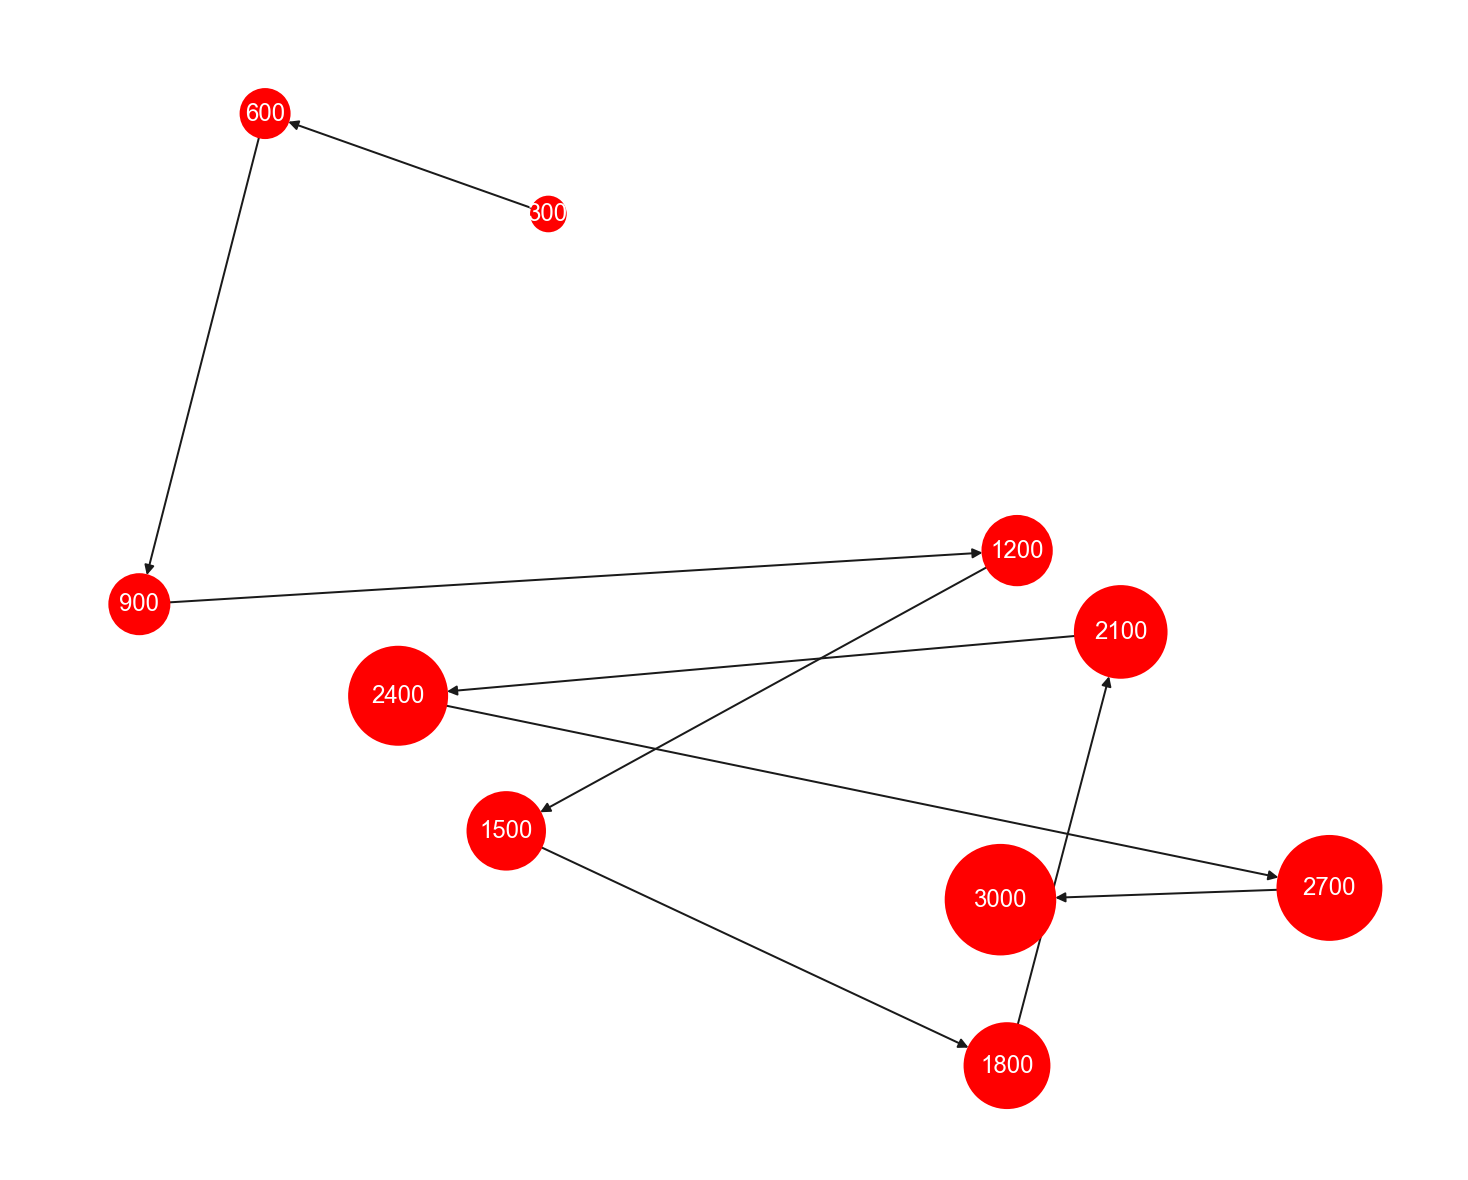

In [261]:
# Create a list of 10 nodes numbered [1, 10]
nodes = range(1,11)
node_sizes = []
labels = {}
for n in nodes:
    node_sizes.append( 300 * n ) #<-- Set the node size
    labels[n] = 300 * n #<-- Set the label of the node as its size

# Connect each node to its successor:
edges = [ (i+1, i+2) for i in range(len(nodes)-1) ] #<-- set the edhes:

# Create the graph and draw it with the node labels
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)

rcParams['figure.figsize'] = 10, 8 #<-- Set the plot size

nx.draw_random(g, node_color = 'Red', node_size = node_sizes, labels=labels, with_labels=True, 
               font_size=12, font_color='White')    
plt.show()


## 5. Degree Centrality

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


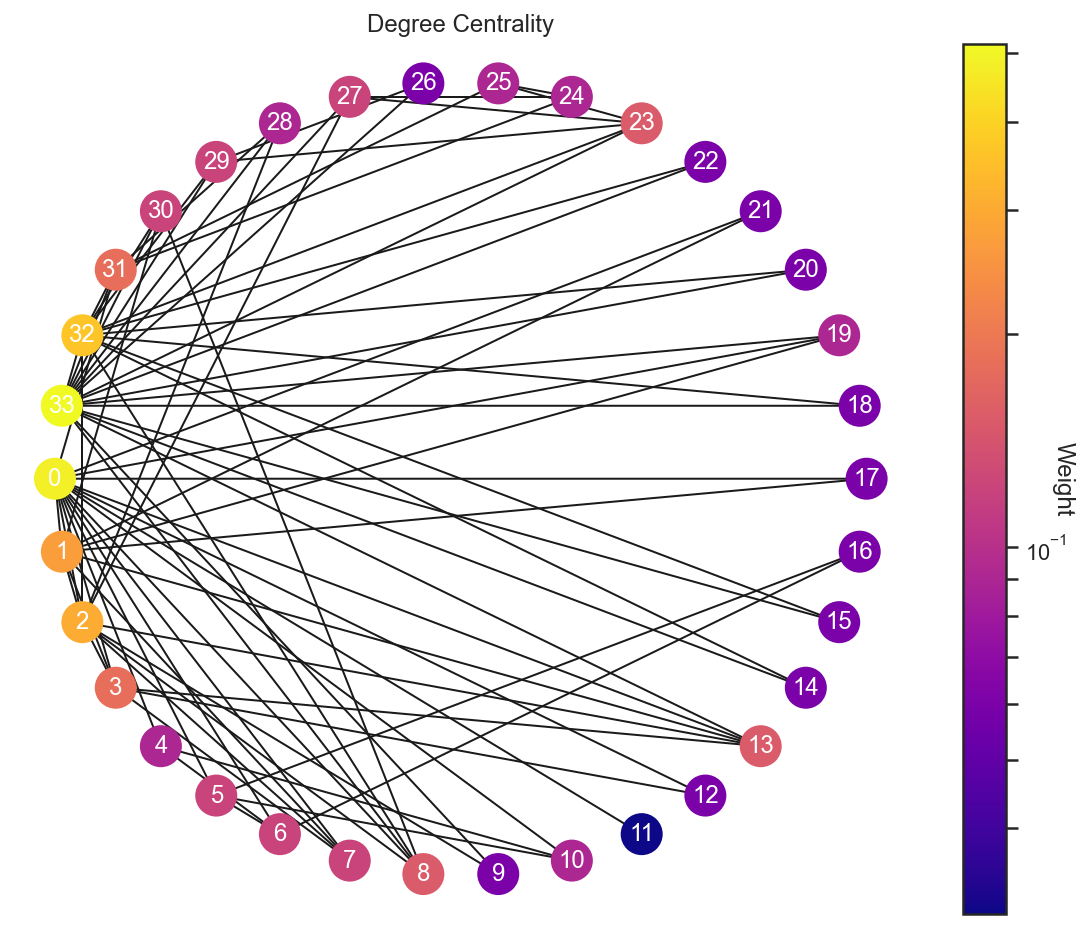

In [268]:
#Plotting the degree centrality as the color if the node using the previous function:
draw(G, pos,nx.degree_centrality(G),'Degree Centrality' )

_Degree_ of a node is basically number of edges that it has.
The basic intuition is that, nodes with more connections are
more influential and important in a network.
In other words, the person with higher friend count in a social network,
the more cited paper (_in-degree_) in a scientific citation network
is the one that is more central according to this metric.

For directed graphs, _in-degree_, number of incoming points, is considered as importance factor for nodes. 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


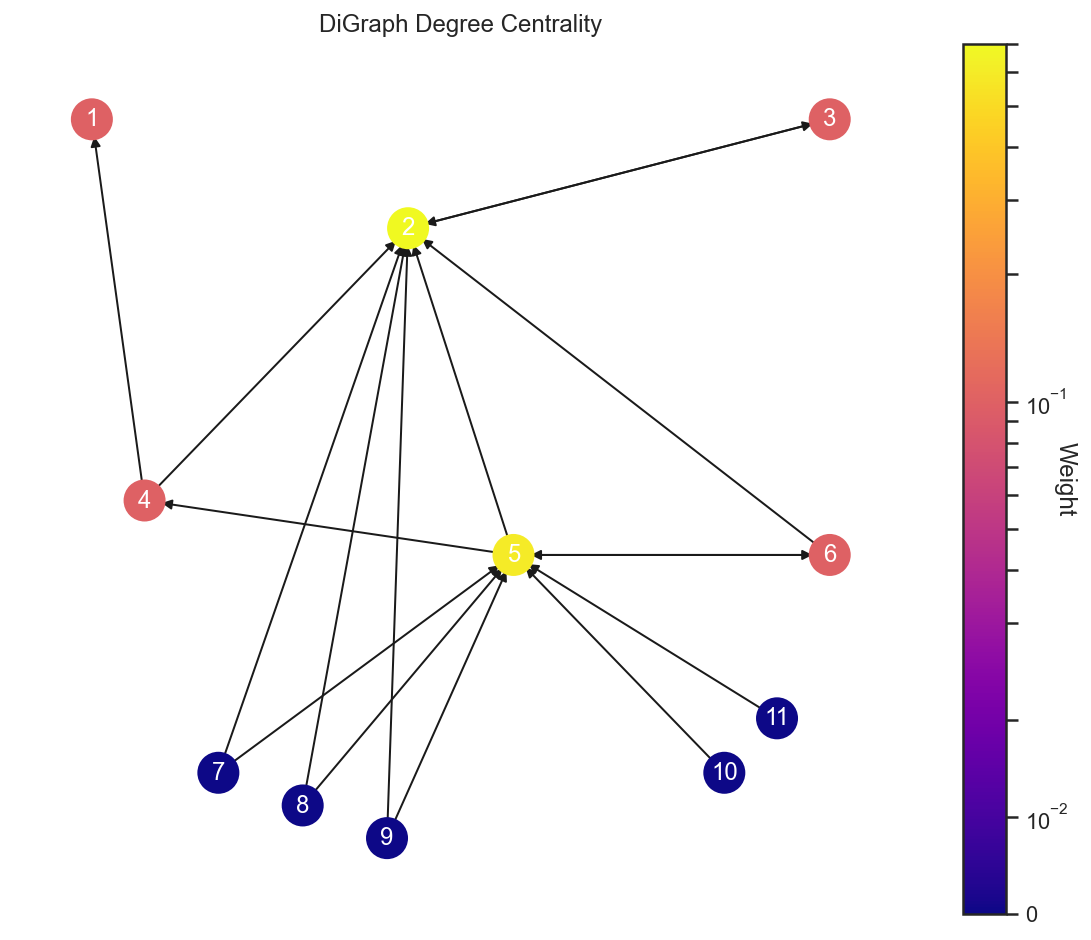

In [269]:
#Plotting the in_degree centrality as the color if the node using the previous function:
draw(DiG, dpos, nx.in_degree_centrality(DiG), 'DiGraph Degree Centrality')

## 6. Eigenvector Centrality

Plotting the eigenvector centrality as the color of the node using the previous function.
The Eigenvector centrality measures the importance of a node based on the importance of its neighbors, it follows a recurside process that can be explained by the eigenvectors of the adjacency matrix.
For an intuitive explanation please visit: https://www.youtube.com/watch?v=1S1mD0l9FwU&ab_channel=JustinRuths



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


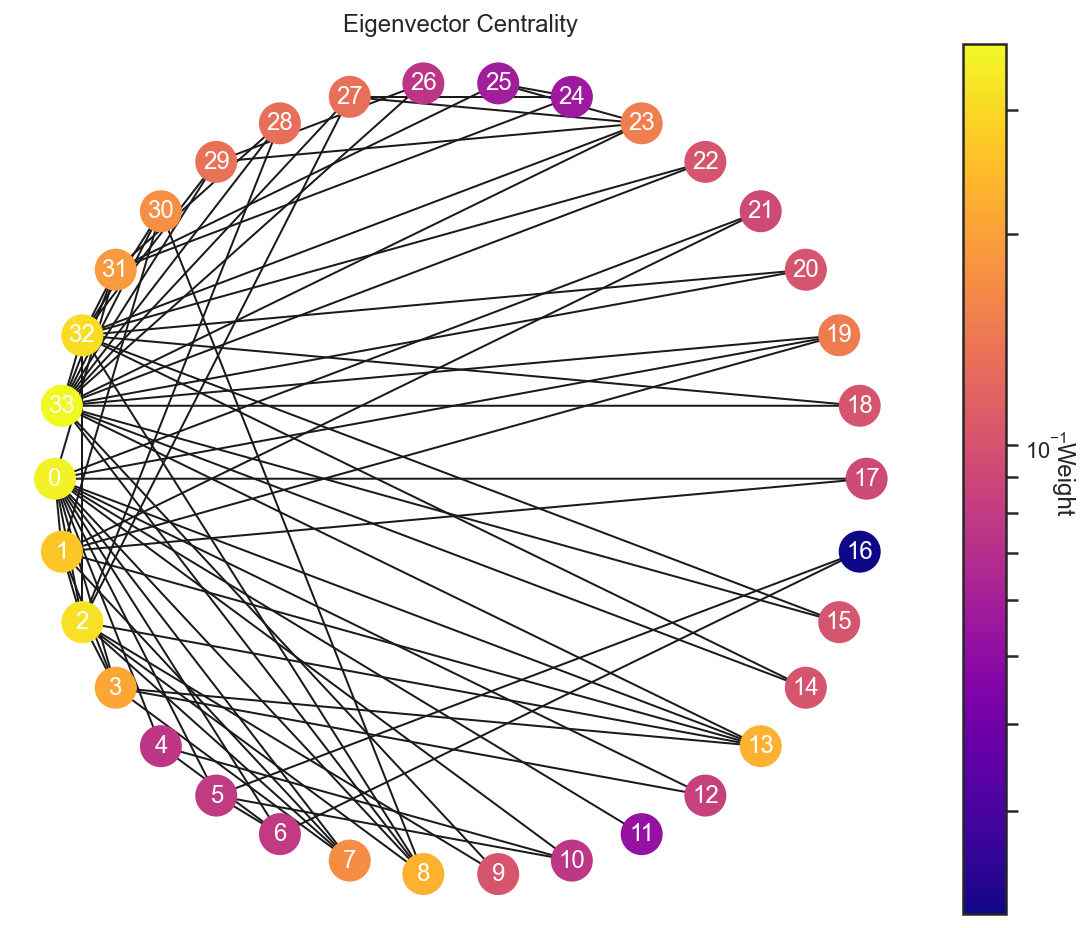

In [270]:
draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

_Eigenvector centrality_ is a basic extension of _degree centrality_,
which defines centrality of a node as proportional to its neighbors' importance.
When we sum up all connections of a node, not all neighbors are equally important.
Let's consider two nodes in a friend network with same degree,
the one who is connected to more central nodes should be more central.

First, we define an initial guess for the centrality of nodes in a graph as $x_i=1$.
Now we are going to iterate for the new centrality value $x_i'$ for node $i$ as following:

$$
  x_i' = \sum_{j} A_{ij}x_j
$$

Here $ A_{ij} $ is an element of _the adjacency matrix_,
where it gives $ 1 $ or $ 0 $ for whether an edge exists between nodes $ i $ and $ j $.
it can also be written in matrix notation as $ \mathbf{x'} = \mathbf{Ax} $.
We iterate over t steps to find the vector $ \mathbf{x}(t) $ as:

$$
  \mathbf{x}(t) = \mathbf{A^t x}(0)
$$

The drawing also shows, the nodes which have the same number of connections are not necessarily in the same heat map color.
The one that is connected to more central nodes are more _hot_ in this visualization.

However, as we can see from the definition,
it is a problematic measure for directed graphs.
Let's say that a new research paper is published and it references a handful of existing papers.
It would not contribute to any of those referenced papers in this citation network
because it is not cited by any other papers and has zero _eigenvector centrality_.
In other words, _eigenvector centrality_ would not take zero _in-degree_ nodes into account
in directed graphs such as citation networks.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


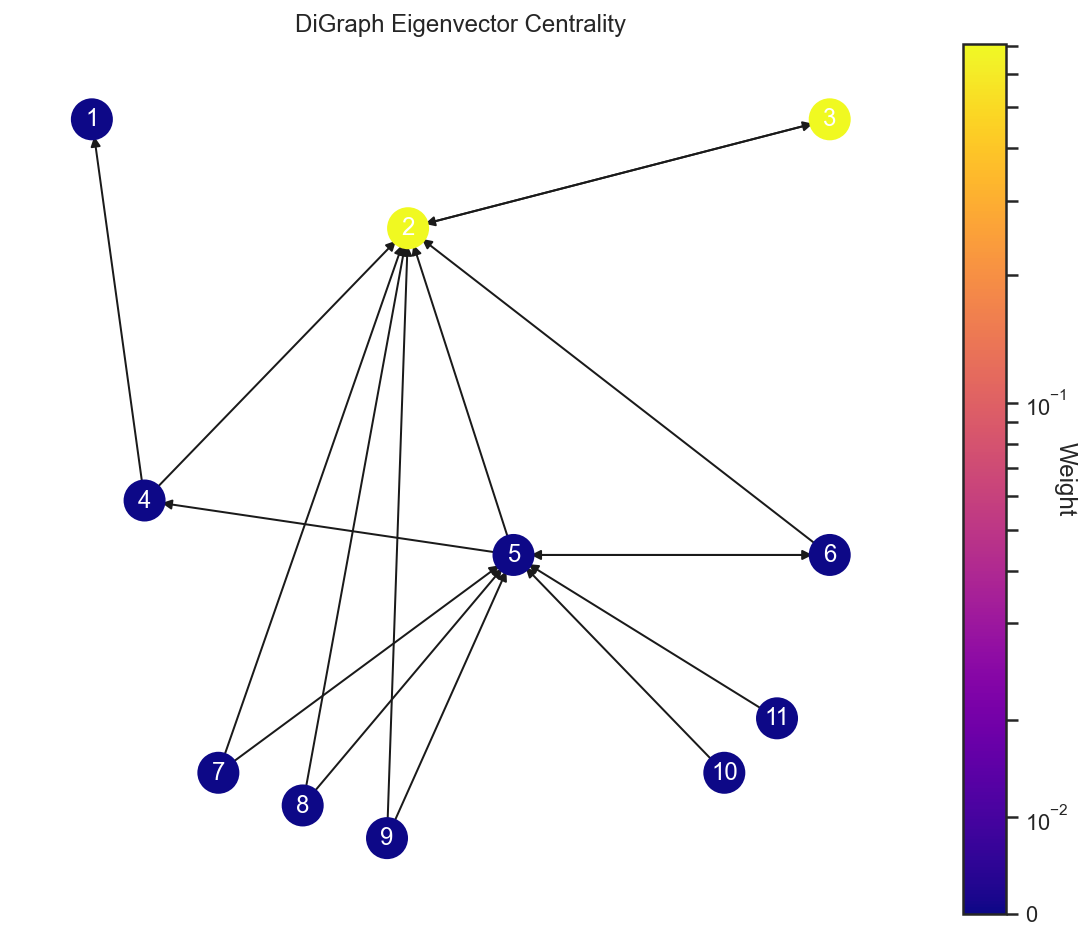

In [271]:
draw(DiG, dpos, nx.eigenvector_centrality_numpy(DiG), 'DiGraph Eigenvector Centrality')

Here the contribution from zero _in-degree_ nodes is zero; consequently, all values are zero except two nodes which are referencing each other.

## 7. Katz Centrality

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


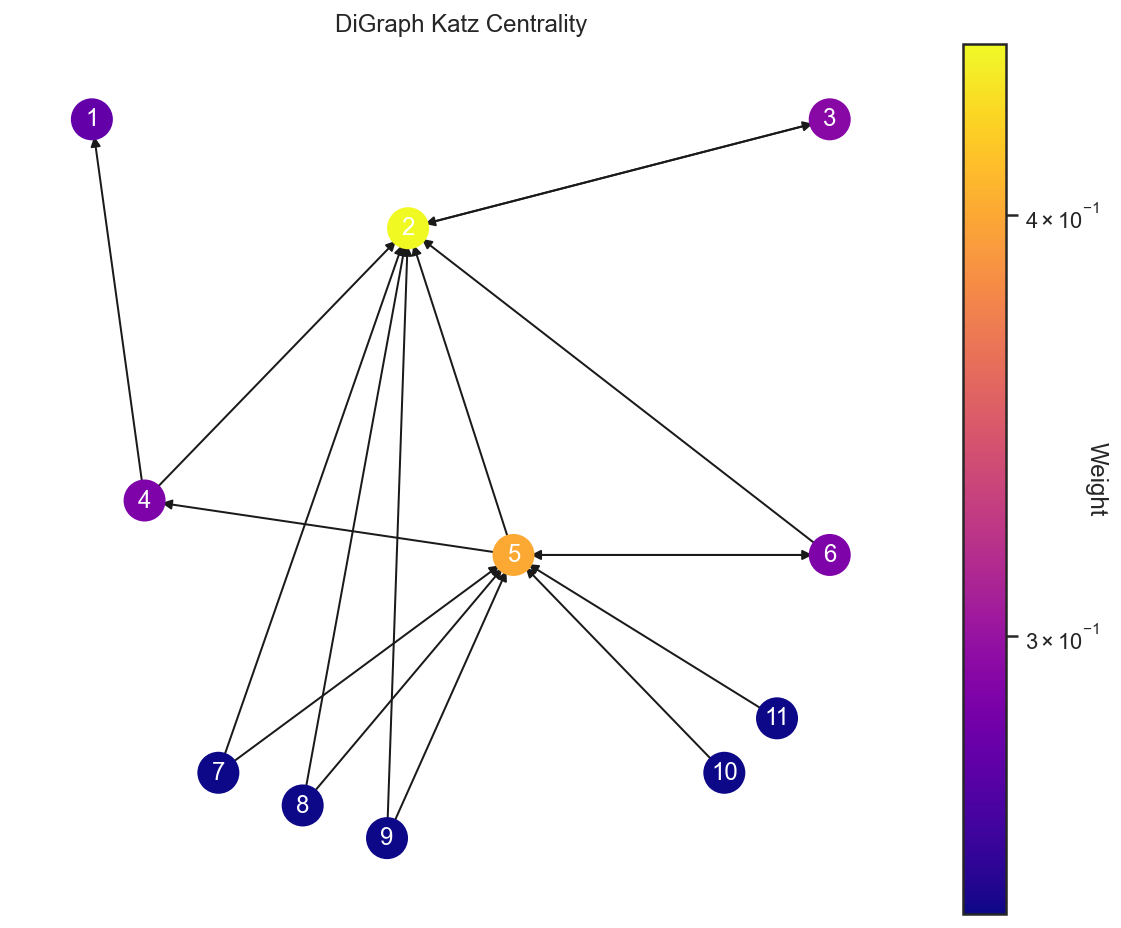

In [272]:
draw(DiG, dpos, nx.katz_centrality(DiG, alpha=0.1, beta=1.0), 'DiGraph Katz Centrality')

_Katz centrality_ introduces two positive constants $ \alpha $ and $ \beta $
to tackle the problem of _eigenvector centrality_ with zero in-degree nodes:

$$
    x_i = \alpha \sum_{j} A_{ij} x_j + \beta,
$$

again $ A_{ij} $ is an element of _the adjacency matrix_,
and it can also be written in matrix notation as $ \mathbf{x} = \alpha \mathbf{Ax} + \beta \mathbf{1} $.
This $ \beta $ constant gives a _free_ centrality contribution for all nodes
even though they don't get any contribution from other nodes.
The existence of a node alone would provide it some importance.
$ \alpha $ constant determines the balances between the contribution from other nodes and the _free_ constant.

Although this method is introduced as a solution for directed graphs,
it can be useful for some applications of undirected graphs as well.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


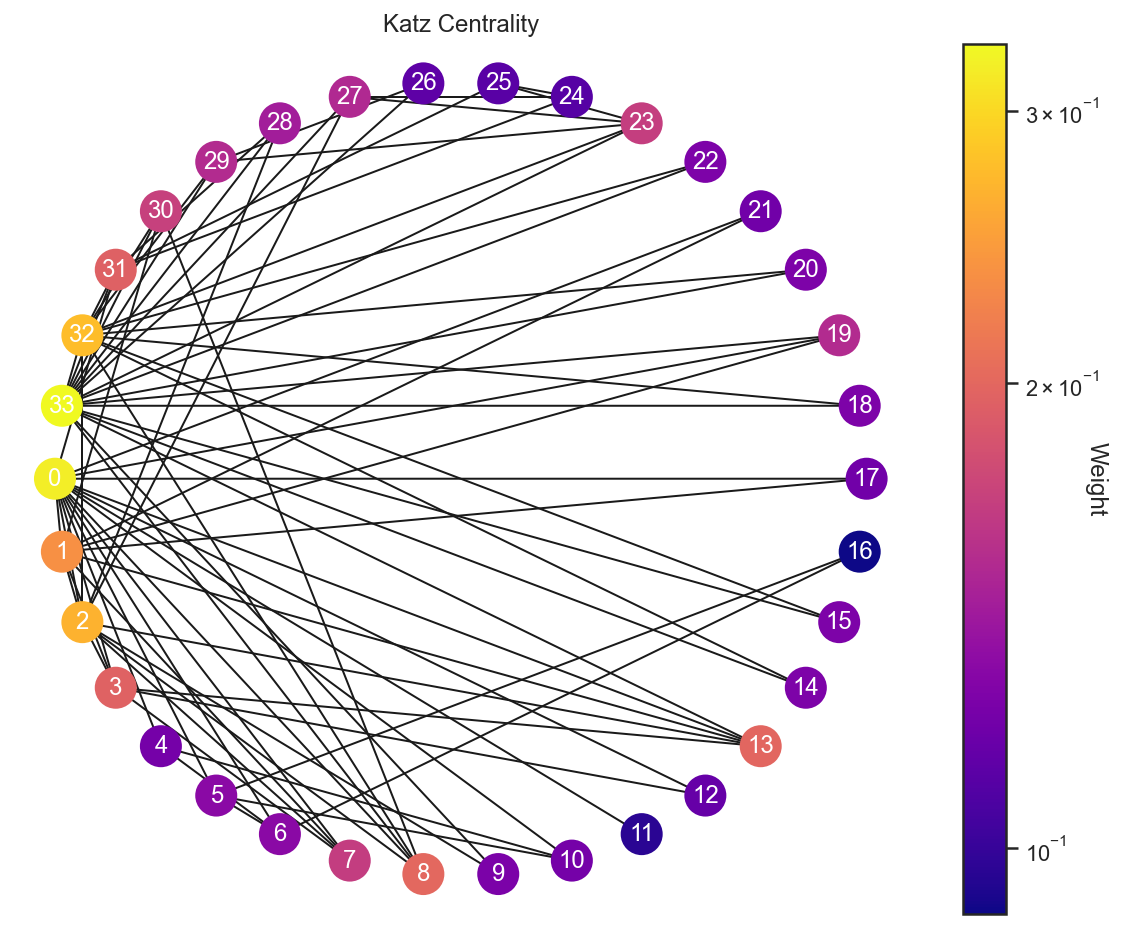

In [273]:
draw(G, pos, nx.katz_centrality(G, alpha=0.1, beta=1.0), 'Katz Centrality')

## 8. Closeness Centrality

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


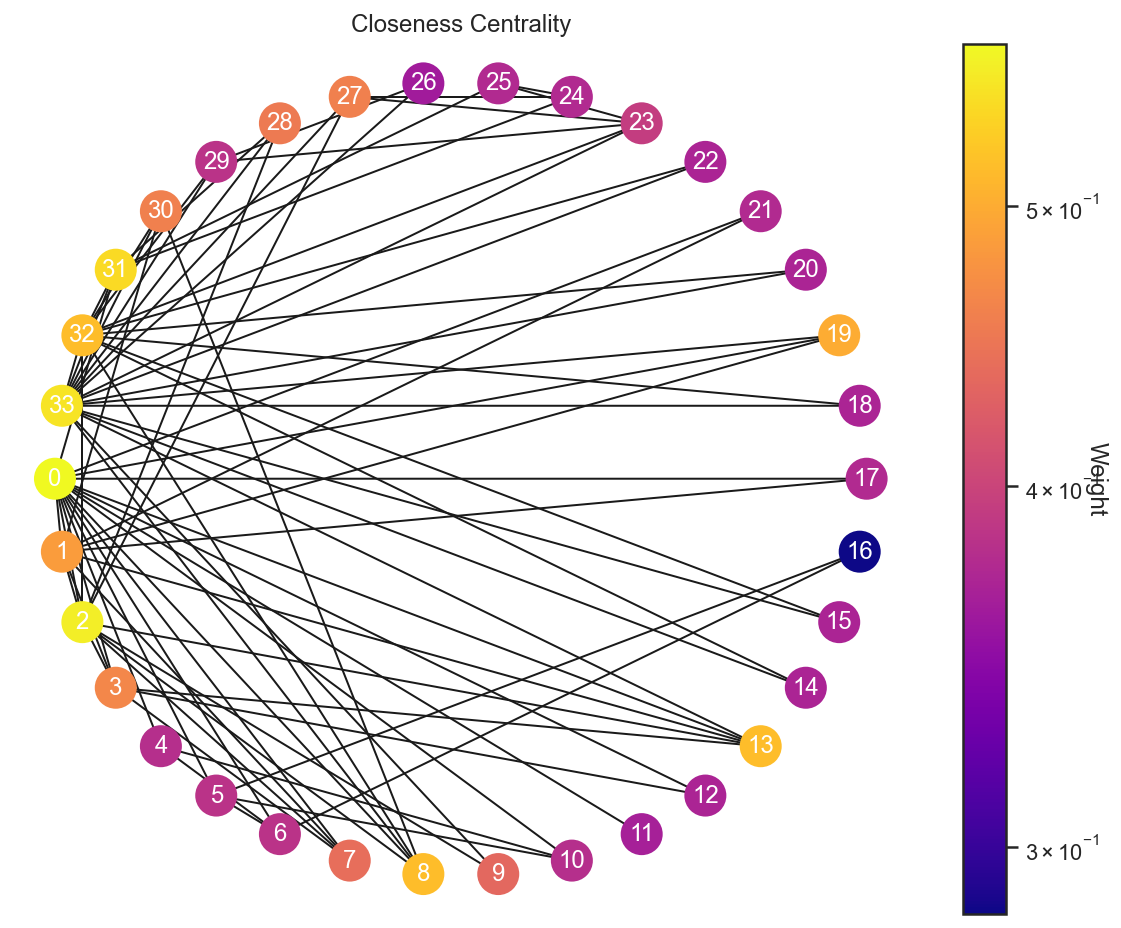

In [274]:
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')

 _Closeness Centrality_ is a self-explanatory measure where each node's importance is determined by closeness to all other nodes. Let $d_{ij}$ be the length of the shortest path between nodes $i$ and $j$, the average distance $l_i$ is such as:
 
$$
  l_i = \dfrac{1}{n} \sum_{j}d_{ij}
$$

Since we are looking for the closer node, the _Closeness Centrality_ $C_i$ is inverse proportional to average length $l_i$, so:

$$
  C_i = \dfrac{1}{l_i} = \dfrac{n}{\sum_{j}d_{ij}}
$$

Here we are using an _unweighted_ graph and all edges have weight $1$ distance cost for calculating shortest path length $d_{ij}$. This measure can be used to determine the central distribution point in a delivery network.

PageRank was introduced by the founders of Google to rank websites in search results.
It can be considered as an extension of _Katz centrality_.
The websites on the web can be modeled as a directed graph,
where hypermedia links between websites determines the edges.
Let's consider a popular web directory website with high _Katz centrality_ value which has millions of links to other websites.
It would contribute to every single website significantly, nevertheless not all of them are important.
To overcome that issue, contribution value is divided by _out-degree_ of the node:

$$
    x_i = \alpha \sum_{j} A_{ij} \frac{x_j}{k_j^{out}} + \beta,
$$

where $ k_j^{out} = 1 $ for zero out-degree nodes to avoid division by zero.
It can also be written in matrix terms as:

$$
    \mathbf{x} = \alpha \mathbf{A D^{-1} x} + \beta \mathbf{1},
$$

where $  \mathbf{D} $ is a diagonal matrix with elements $ D_{ii} = max(k_i^{out}, 1) $.

As the drawing demonstrates, the nodes with fewer _out-degree_ contributes way more to each node compared the _Katz Centrality_. Here the node at the top right gets only reference of a very important node, and it becomes way more important compared to the _Katz Centrality_; on the other hand, the node in the center which gets contribution from high _out-degree_ nodes loses its importance.

## 9. Betweenness Centrality

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


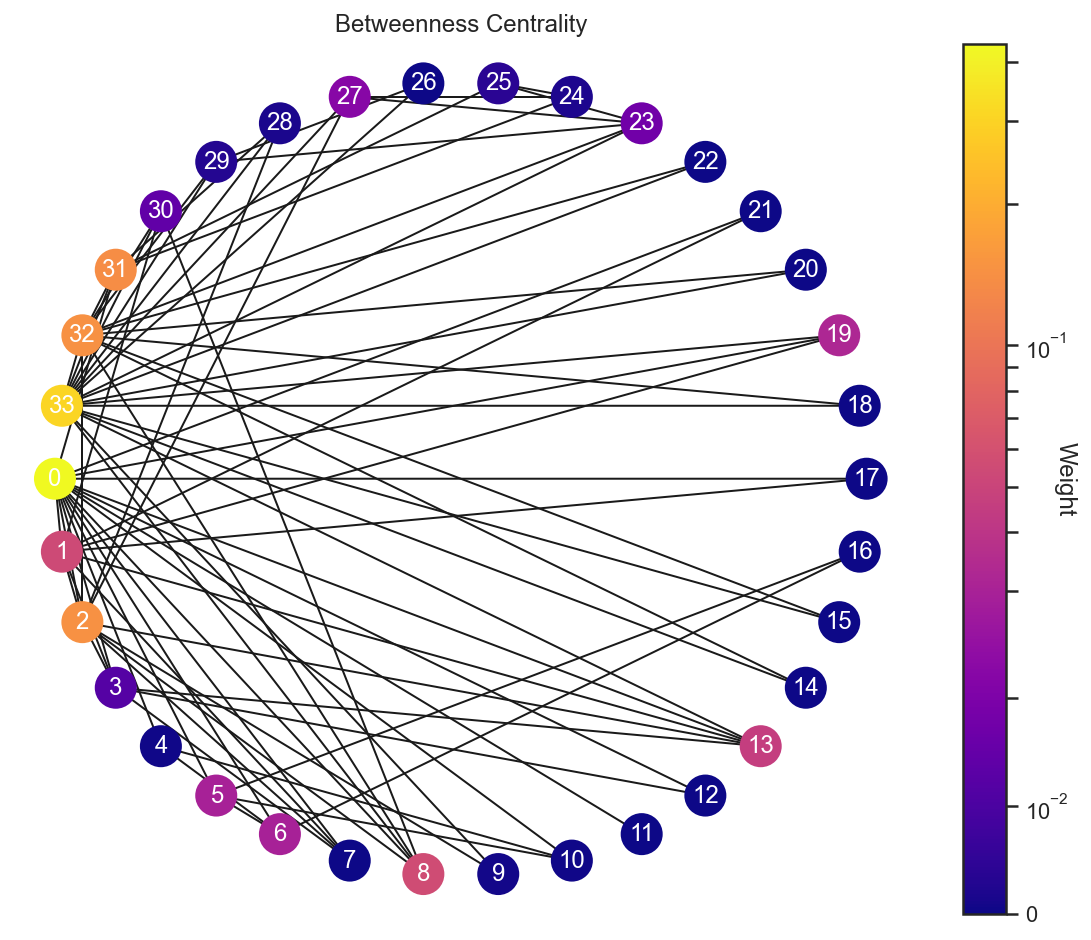

In [275]:
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

_Betweenness Centrality_ is another centrality that is based on shortest path between nodes. It is determined as number of the shortest paths passing by the given node. For starting node $s$, destination node $t$ and the input node $i$ that holds $s \ne t \ne i$, let $n_{st}^i$ be 1 if node $i$ lies on the shortest path between $s$ and $t$; and $0$ if not. So the _betweenness centrality_ is defined as:

$$
  x_i = \sum_{st} n_{st}^i
$$

However, there can be more than one shortest path between $s$ and $t$ and that will count for centrality measure more than once. Thus, we need to divide the contribution to $g_{st}$, total number of shortest paths between $s$ and $t$.

$$
  x_i = \sum_{st} \frac{n_{st}^i}{g_{st}}
$$

**References and further reading**

* Newman, Mark. *Networks: An Introduction* (pp. 168-234, Chapter 7: Measures and Metrics)., Oxford University Press, 2010.
* Zachary, Wayne W. *An Information Flow Model for Conflict and Fission in Small Groups*., 1977.

## 10. Comparison on Centrality Metrics

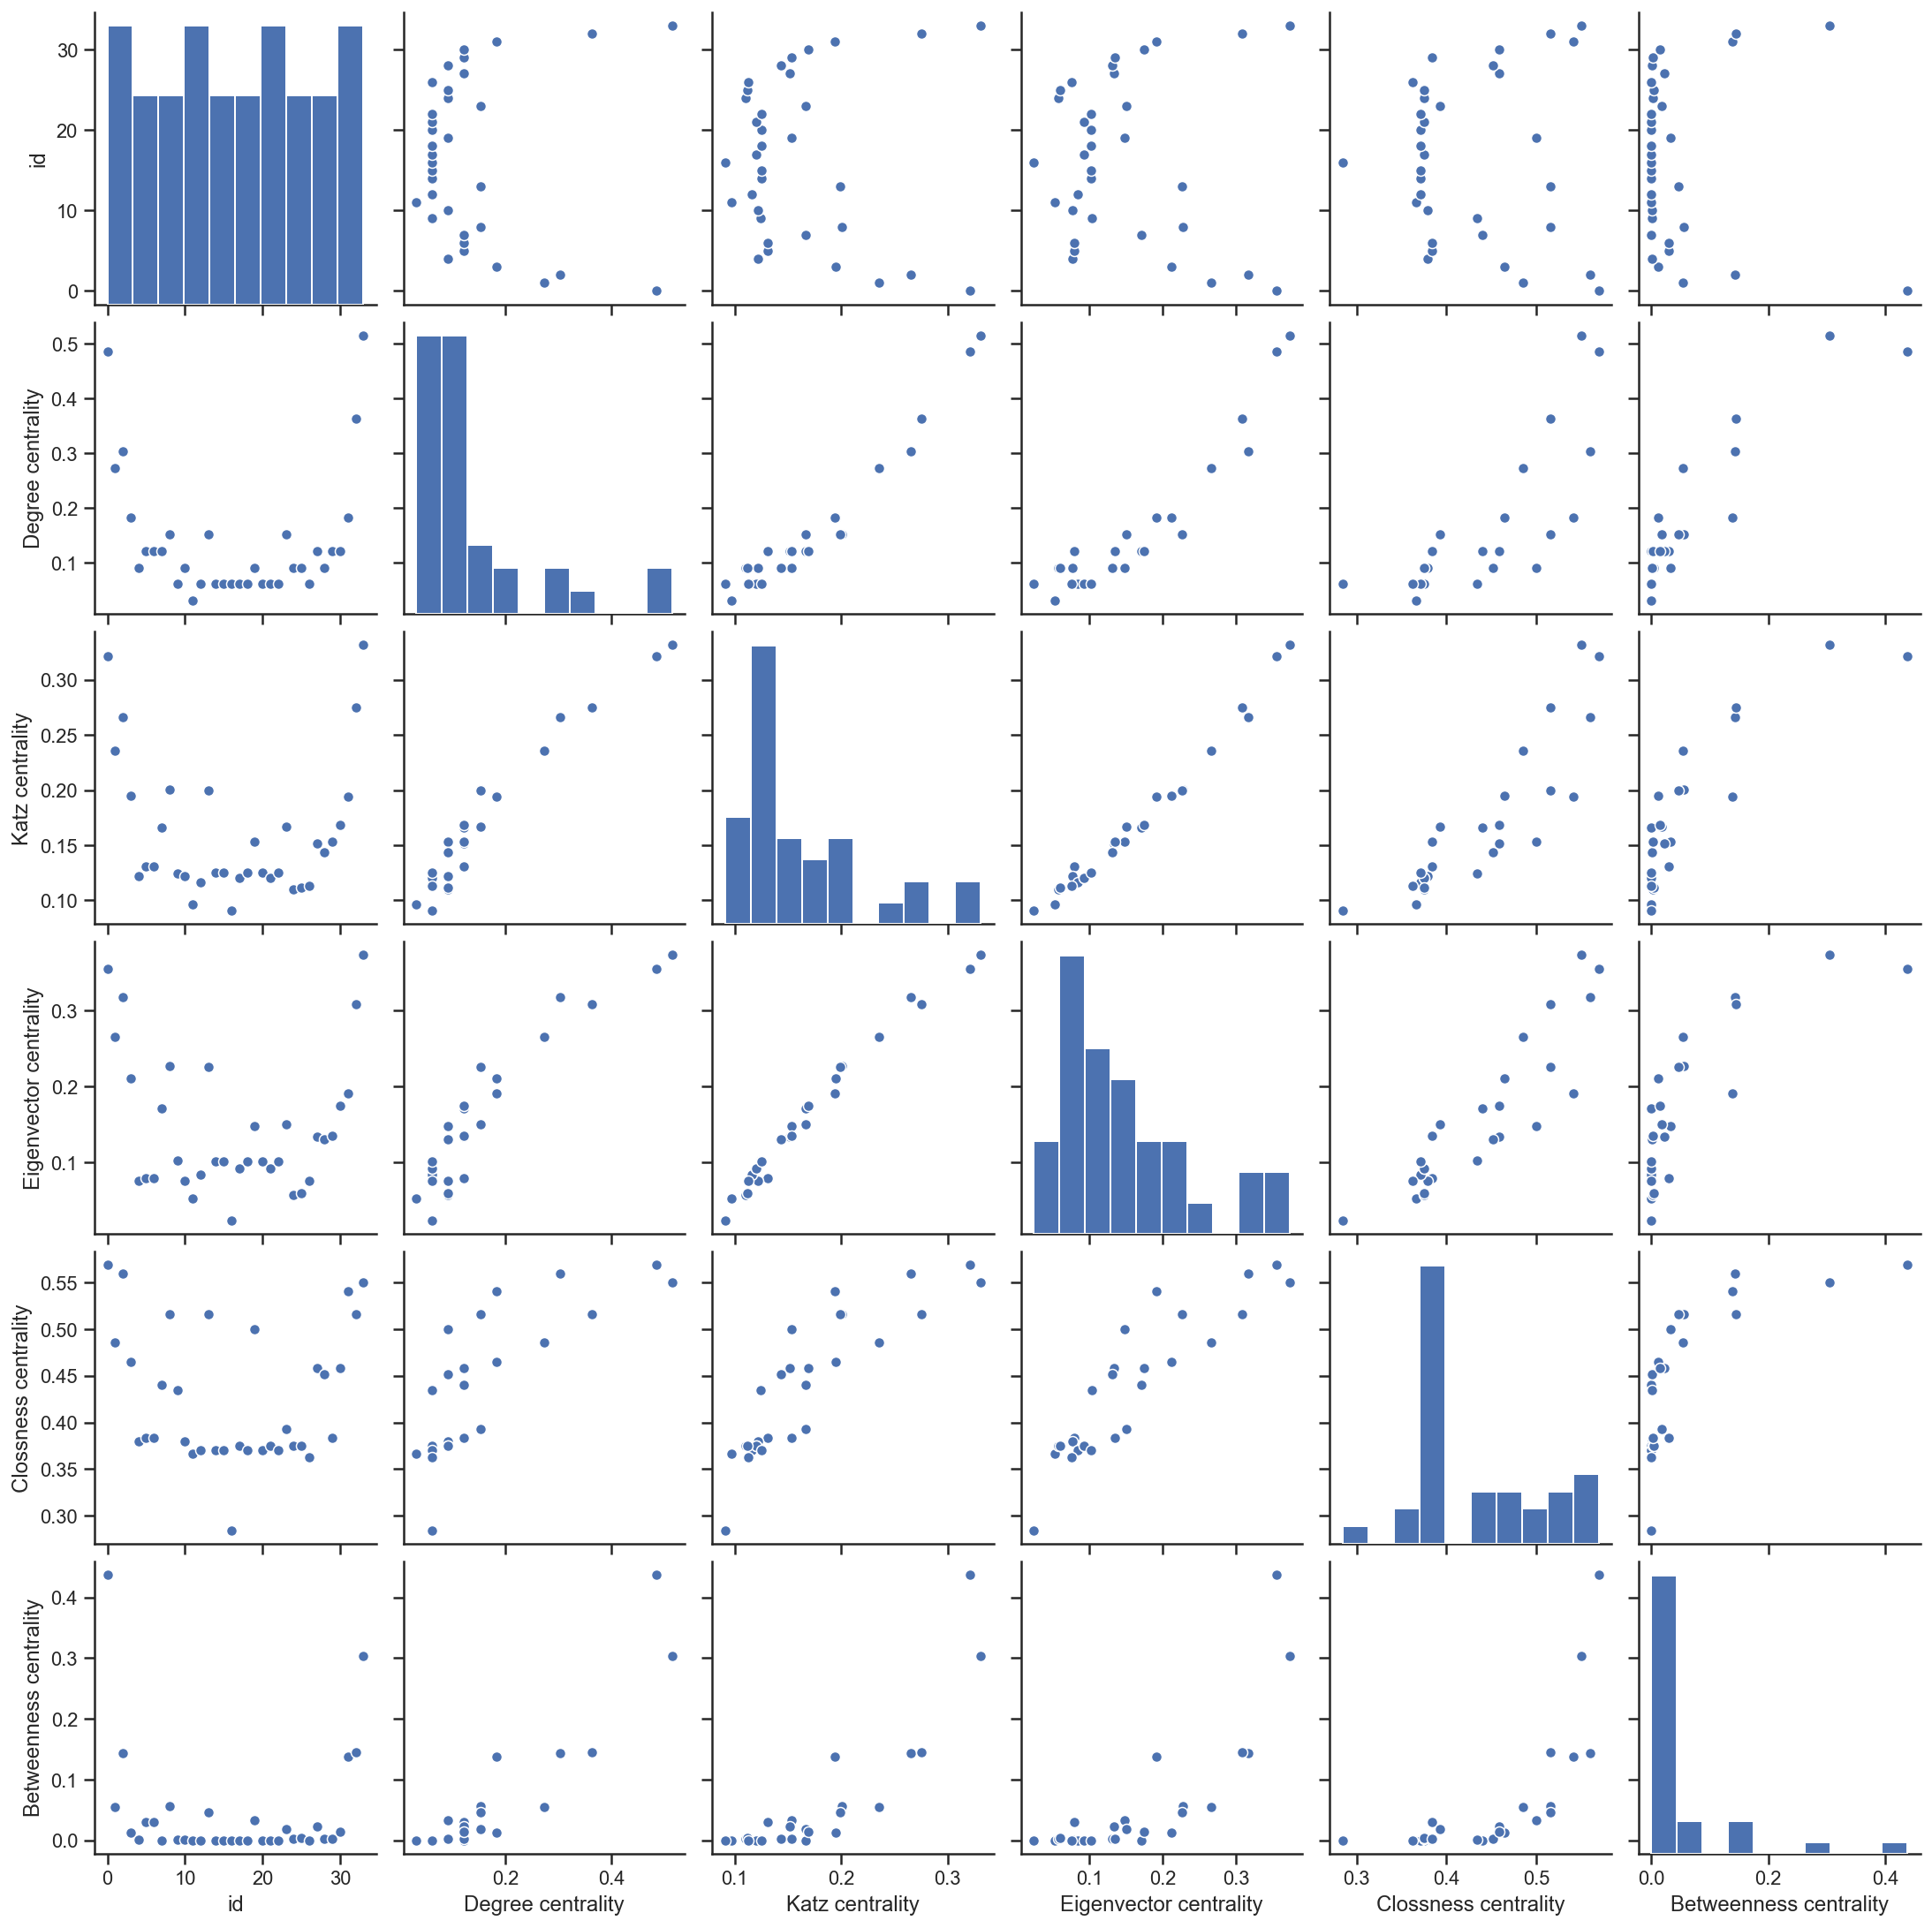

In [113]:
#Create a list with all the previous measures:
dataset1=[]
for k in nx.degree_centrality(G).keys():
    dataset1.append([k,nx.degree_centrality(G)[k],nx.katz_centrality(G)[k],nx.eigenvector_centrality(G)[k],
                    nx.closeness_centrality(G)[k],nx.betweenness_centrality(G)[k]])

#Set the grid for the multiple plot:
rcParams['figure.figsize'] = 5, 5 #<-- Set the plot size
sns.set(style="ticks")

#Create a dataframe with the results of the measures:
df=pd.DataFrame(dataset1,columns=['id','Degree centrality','Katz centrality','Eigenvector centrality','Clossness centrality','Betweenness centrality'])

#Plot the dataframe variables:
sns.pairplot(df)

## 11. K-Core

_K-core_ detects the node in the core of the network which make them more central. This algorithm is itterative and it starts removing all the nodes with degree 1. The degree of the node sis updated and then we check again if there are nodes of degree 1 and we remove them too. If there are no more nodes of degree 1 the k is increased to 2 and all the nodes with degree 2 are removed, degrees are updated, and we remove all remaining nodes with degree 2 or less. We increase the value of k until all nodes of the network are removed. The last group of nodes in being removed are those with the largest k-core and k takes the value of the last increase. **The centrality of each node is the value of the core in which the node was removed.**

In [277]:
nx.core_number??

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


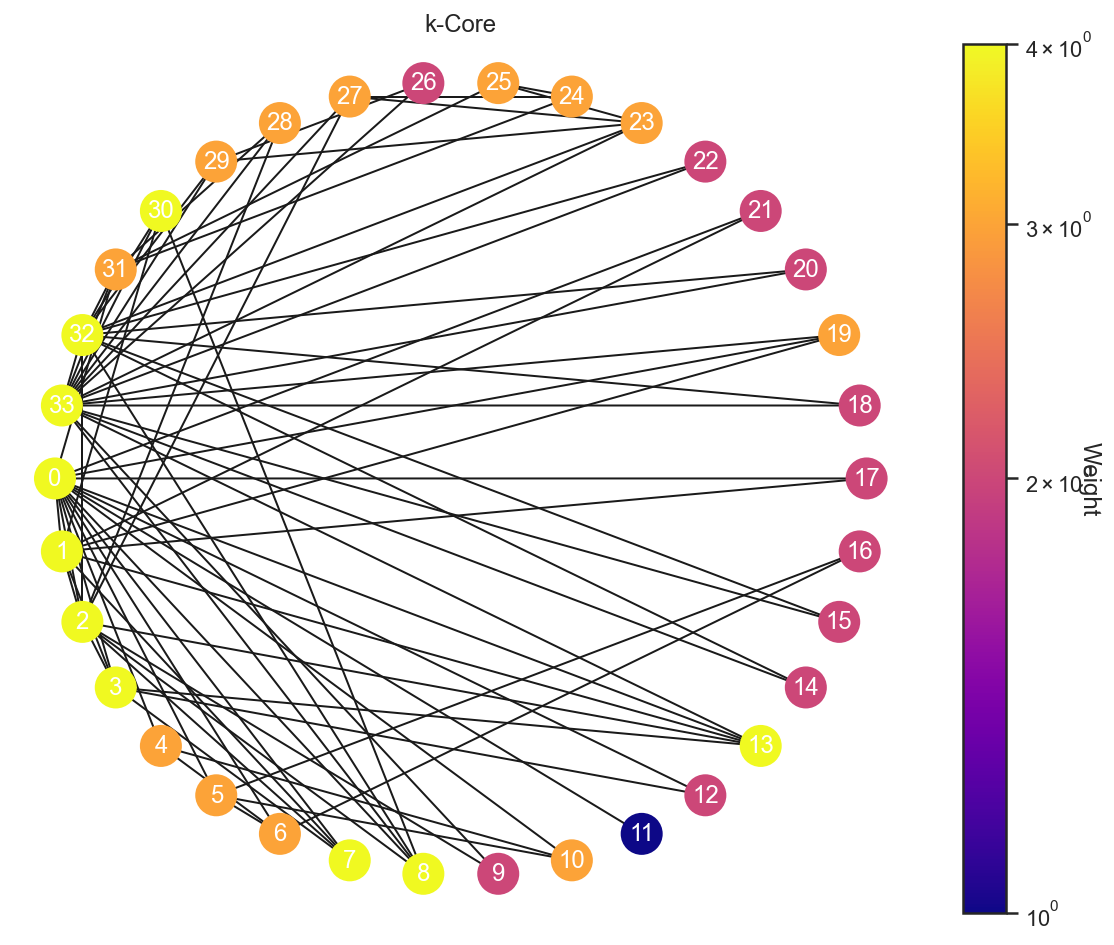

In [276]:
draw(G, pos, nx.core_number(G), 'k-Core')

In [368]:
#Eigen_vector centrality:
#------------------------
from scipy.sparse import linalg #<-- Import the library of the linear operators

M = nx.to_scipy_sparse_matrix(G, nodelist=list(G), dtype=float) #<-- Select a sparce adjacency matrix of the network
eigenvalue, eigenvector = linalg.eigs(M) #<-- Calculate the eigenvectors and 
                                                             #egienvalues of the matrix
selected_eigenvector = eigenvector.flatten().real #<-- Select the largest eigenvalue and the correspondent eigenvector


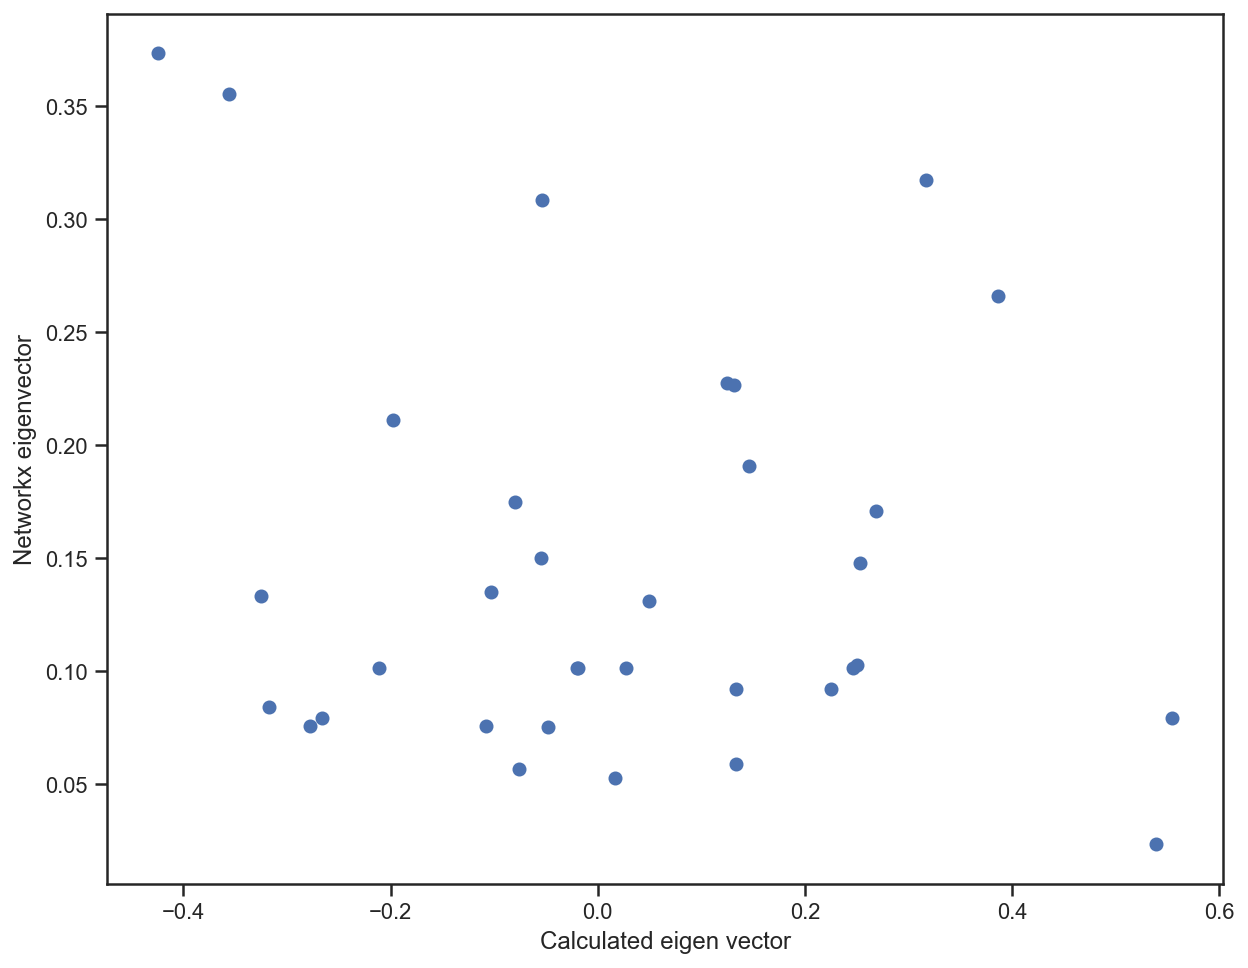

In [369]:
plt.scatter(list(selected_eigenvector)[:34], dict(nx.eigenvector_centrality_numpy(G)).values())
plt.xlabel('Calculated eigen vector') #<-- Plot in the x axis the calculated metric
plt.ylabel('Networkx eigenvector') #<-- Plot the networkx metric
plt.show()